# Estimación del cambio de precio prima del indicador Return of Withholding of Capacity



In [1]:
!pip install tradingeconomics
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from datetime import date

from pandas_datareader.data import DataReader
series_code = 'EFFR'
data_source = 'fred'
start = date(2017, 1, 1)

import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_white, het_breuschpagan


from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, classification_report, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Creación de Dataset

## API Trading Economics

In [3]:
import tradingeconomics as te
te.login('d7530524c3b446b:2pbn4fjadlq5ndm')

'Logged with d7530524c3b446b'

In [4]:
# te.getIndicatorData(country='mexico')

In [5]:

te.getIndicatorData(country='mexico', output_type='df')

,Country,Category,Title,LatestValueDate,LatestValue,Source,SourceURL,Unit,URL,CategoryGroup,Adjustment,Frequency,HistoricalDataSymbol,CreateDate,FirstValueDate,PreviousValue,PreviousValueDate
0,Mexico,Withholding Tax Rate,Mexico Withholding Tax Rate,2023-12-31T00:00:00,35.00,"Servicio de Administración Tributaria, SHCP",,percent,/mexico/withholding-tax-rate,Taxes,NSA,Yearly,MEXWTR,2023-04-27T21:19:00,2022-12-31T00:00:00,35.00,2022-12-31T00:00:00
1,Mexico,Wages in Manufacturing,Mexico Nominal Hourly Wages in Manufacturing,2023-09-30T00:00:00,4.00,Instituto Nacional de Estadística y Geografía ...,https://www.inegi.org.mx/,USD/Hour,/mexico/wages-in-manufacturing,Labour,"Current Prices, NSA",Monthly,MEXICOWAGINMAN,2012-09-29T00:51:00,2007-01-31T00:00:00,3.90,2023-08-31T00:00:00
2,Mexico,Wages,Mexico Average Daily Wages,2023-10-31T00:00:00,531.55,"Secretariat of Labor & Soc Welf, Mexico",https://www.gob.mx,MXN/Day,/mexico/wages,Labour,"Current Prices, NSA",Monthly,MEXICOWAG,2012-09-29T00:51:00,2000-01-31T00:00:00,532.23,2023-09-30T00:00:00
3,Mexico,Unemployment Rate,Mexico Unemployment Rate,2023-10-31T00:00:00,2.70,Instituto Nacional de Estadística y Geografía ...,http://www.inegi.org.mx/,percent,/mexico/unemployment-rate,Labour,NSA,Monthly,MXUEUNSA,2013-01-17T15:22:00,1994-05-31T00:00:00,2.90,2023-09-30T00:00:00
4,Mexico,Unemployed Persons,Mexico Unemployed Persons,2023-09-30T00:00:00,1825196.00,Instituto Nacional de Estadística y Geografía ...,https://www.inegi.org.mx/,,/mexico/unemployed-persons,Labour,"Volume, NSA",Quarterly,MEXICOUNEPER,2012-09-29T00:50:00,2000-06-30T00:00:00,1694442.00,2023-06-30T00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Mexico,Capacity Utilization,Mexico Capacity Utilization,2023-09-30T00:00:00,78.70,Instituto Nacional de Estadística y Geografía ...,https://www.inegi.org.mx/,percent,/mexico/capacity-utilization,Business,NSA,Monthly,MEXICOCAPUTI,2012-09-28T18:34:00,2007-01-31T00:00:00,78.00,2023-08-31T00:00:00
137,Mexico,Business Confidence,Mexico Business Confidence,2023-11-30T00:00:00,54.00,Instituto Nacional de Estadística y Geografía ...,http://en.www.inegi.org.mx/,points,/mexico/business-confidence,Business,SA,Monthly,MexicoBC,2012-09-04T10:02:00,2004-01-31T00:00:00,54.00,2023-10-31T00:00:00
138,Mexico,Banks Balance Sheet,Mexico Banks Balance Sheet,2023-09-30T00:00:00,10813847.06,Banco de México,http://www.banxico.org.mx,MXN Million,/mexico/banks-balance-sheet,Money,NSA,Monthly,MEXICOBANBALSHE,2014-09-08T15:29:00,2000-12-31T00:00:00,10702998.84,2023-08-31T00:00:00
139,Mexico,Balance of Trade,Mexico Balance of Trade,2023-10-31T00:00:00,-252.50,Instituto Nacional de Estadística y Geografía ...,https://www.inegi.org.mx/,USD Million,/mexico/balance-of-trade,Trade,NSA,Monthly,MXTBBAL,2014-07-25T14:01:00,1980-01-31T00:00:00,-1481.38,2023-09-30T00:00:00


In [6]:
#te.getMarketsSymbology(country = 'mexico', output_type='df')

In [7]:
# te.getIndicatorData(country=['mexico', 'sweden'], output_type='df')
#te.getMarketsData(marketsField = 'commodities', output_type = 'df')
#te.getMarketsData(marketsField = 'commodities')

In [8]:
te.fetchMarkets(symbol='coal:us', initDate='2017-01-01')

[{'Symbol': 'Free accounts have access to the following countries: Mexico, New Zealand, Sweden, Thailand. For more, contact us at support@tradingeconomics.com.',
  'Date': '04/12/2023',
  'Open': None,
  'High': None,
  'Low': None,
  'Close': None}]

## Dataset energia

In [9]:
df_energy_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/Energia/DemandaResidual_PML.xlsx")

df_energy_m['fecha'] = pd.to_datetime(df_energy_m['FECHA'])
df_energy_m.set_index(df_energy_m['fecha'])


df_energy_m.head(10)

,FECHA,ANIO,MES,MES_STRING,CLV_CONCEPTO,PML_MDA,MONTO,FOTOVOLTAICA,TERMICA,BIOMASA,...,EOLICA,COMBUSTION_INTERNA,GEOTERMOELECTRICA,HIDROELECTRICA,CICLO_COMBINADO,NUCLEOELECTRICA,CARBOELECTRICA,LOAD_MW,RESID_DEMAND_MW,fecha
0,2016-01-01,2016,1,1,PaEneGen_MDA,631.41,1.335370e+09,1202.520,145843.850,54.71,...,113217.831,3883.430,65620.47,198182.740,1.224252e+06,48096.99,227235.97,2541.26,2107.09,2016-01-01
1,2016-02-01,2016,2,2,PaEneGen_MDA,653.78,1.342591e+10,10765.090,2081293.952,589.72,...,1248465.111,34681.270,469871.66,2102993.112,1.093359e+07,436278.45,2480512.42,24224.76,19555.00,2016-02-01
2,2016-03-01,2016,3,3,PaEneGen_MDA,628.65,1.369306e+10,12541.980,2575186.351,671.63,...,518040.170,80310.438,465597.40,2934860.218,1.225387e+07,251273.41,2498139.51,26564.75,21751.64,2016-03-01
3,2016-04-01,2016,4,4,PaEneGen_MDA,710.64,1.631363e+10,13199.030,2947887.656,623.50,...,1209566.177,149581.410,476501.78,3422298.263,1.169380e+07,558805.08,2736033.69,27395.83,20944.36,2016-04-01
4,2016-05-01,2016,5,5,PaEneGen_MDA,962.57,2.412800e+10,13989.770,3052772.053,719.57,...,602446.554,163608.030,502655.25,3790387.357,1.292477e+07,909887.43,3052328.40,30246.50,24125.91,2016-05-01
5,2016-06-01,2016,6,6,PaEneGen_MDA,1005.14,2.476586e+10,13587.353,3723857.620,75.55,...,514803.004,183233.430,494608.38,3074350.130,1.318715e+07,1085577.00,3076632.25,31875.96,26872.15,2016-06-01
6,2016-07-01,2016,7,7,PaEneGen_MDA,1094.15,2.866041e+10,14695.617,3921046.736,0.00,...,794235.372,215206.631,471932.26,2883168.939,1.352230e+07,1143054.00,3089558.33,33171.57,28043.65,2016-07-01
7,2016-08-01,2016,8,8,PaEneGen_MDA,963.52,2.531985e+10,17679.430,3758554.345,0.00,...,627855.485,235605.146,493198.54,2998526.012,1.349120e+07,1126507.00,2928342.81,32784.56,27723.36,2016-08-01
8,2016-09-01,2016,9,9,PaEneGen_MDA,1119.76,2.750395e+10,18416.717,3640625.255,86.40,...,618681.550,208080.085,481617.81,2570899.131,1.335089e+07,1030333.00,2325418.46,31403.75,26948.20,2016-09-01
9,2016-10-01,2016,10,10,PaEneGen_MDA,1026.37,2.461912e+10,18412.980,3330366.552,0.00,...,1095053.832,205905.528,484508.48,2099222.025,1.332713e+07,1096220.00,2189122.46,30883.04,26420.98,2016-10-01


In [10]:
rename_dict = {
    'ANIO': 'anio',
    'MES' : 'mes',
    'RESID_DEMAND_MW' : 'resid'
}

df_energy_m.rename(columns=rename_dict, inplace=True)


In [11]:
print(df_energy_m.info())
df_energy_m.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FECHA               94 non-null     object        
 1   anio                94 non-null     int64         
 2   mes                 94 non-null     int64         
 3   MES_STRING          94 non-null     int64         
 4   CLV_CONCEPTO        94 non-null     object        
 5   PML_MDA             94 non-null     float64       
 6   MONTO               94 non-null     float64       
 7   FOTOVOLTAICA        94 non-null     float64       
 8   TERMICA             94 non-null     float64       
 9   BIOMASA             94 non-null     float64       
 10  TURBOGAS            94 non-null     float64       
 11  EOLICA              94 non-null     float64       
 12  COMBUSTION_INTERNA  94 non-null     float64       
 13  GEOTERMOELECTRICA   94 non-null     float64       
 

,FECHA,anio,mes,MES_STRING,CLV_CONCEPTO,PML_MDA,MONTO,FOTOVOLTAICA,TERMICA,BIOMASA,...,EOLICA,COMBUSTION_INTERNA,GEOTERMOELECTRICA,HIDROELECTRICA,CICLO_COMBINADO,NUCLEOELECTRICA,CARBOELECTRICA,LOAD_MW,resid,fecha
0,2016-01-01,2016,1,1,PaEneGen_MDA,631.41,1.335370e+09,1202.52,145843.850,54.71,...,113217.831,3883.430,65620.47,198182.740,1224252.34,48096.99,227235.97,2541.26,2107.09,2016-01-01
1,2016-02-01,2016,2,2,PaEneGen_MDA,653.78,1.342591e+10,10765.09,2081293.952,589.72,...,1248465.111,34681.270,469871.66,2102993.112,10933586.94,436278.45,2480512.42,24224.76,19555.00,2016-02-01
2,2016-03-01,2016,3,3,PaEneGen_MDA,628.65,1.369306e+10,12541.98,2575186.351,671.63,...,518040.170,80310.438,465597.40,2934860.218,12253871.26,251273.41,2498139.51,26564.75,21751.64,2016-03-01
3,2016-04-01,2016,4,4,PaEneGen_MDA,710.64,1.631363e+10,13199.03,2947887.656,623.50,...,1209566.177,149581.410,476501.78,3422298.263,11693801.94,558805.08,2736033.69,27395.83,20944.36,2016-04-01
4,2016-05-01,2016,5,5,PaEneGen_MDA,962.57,2.412800e+10,13989.77,3052772.053,719.57,...,602446.554,163608.030,502655.25,3790387.357,12924772.35,909887.43,3052328.40,30246.50,24125.91,2016-05-01


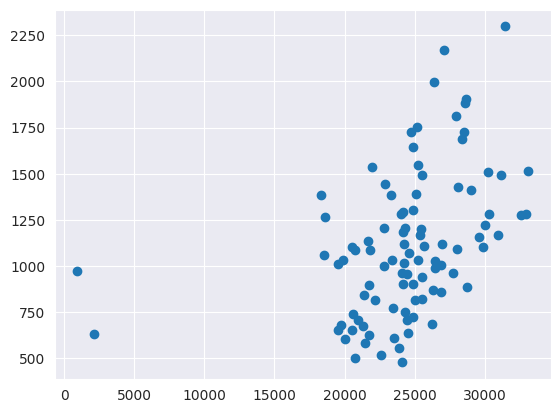

In [12]:
sns.set_style("darkgrid")

x_scatter = df_energy_m['resid']
y_scatter = df_energy_m['PML_MDA']

plt.scatter(x_scatter, y_scatter)

In [13]:
columns = ['FECHA', 'anio', 'mes', 'PML_MDA', 'LOAD_MW',	'resid']

df_energy_m = df_energy_m[columns]

In [14]:
df_energy_m.info()

print(df_energy_m.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FECHA    94 non-null     object 
 1   anio     94 non-null     int64  
 2   mes      94 non-null     int64  
 3   PML_MDA  94 non-null     float64
 4   LOAD_MW  94 non-null     float64
 5   resid    94 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.5+ KB
RangeIndex(start=0, stop=94, step=1)


## Dataset precios de carbón
* INEGI - Indice de precios de carbón mineral
* Coal (API4) FOB Richards Bay (ARGUS-McCloskey)

In [15]:
#df_coal_m = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/PythonEconomia/Tesis/Datasets/Carbon/Coal (API4) FOB Richards Bay (ARGUS-McCloskey) Futures Historical Data_monthly.csv")
df_coal_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/Carbon/IndiceCarbon_Inegi.xlsx")


df_coal_m.head(10)




,fecha,Price
0,2017-01-01,74.718542
1,2017-02-01,76.914027
2,2017-03-01,74.823919
3,2017-04-01,73.655995
4,2017-05-01,77.163662
5,2017-06-01,75.865997
6,2017-07-01,74.717989
7,2017-08-01,74.954035
8,2017-09-01,75.110462
9,2017-10-01,76.906319


In [16]:
print(df_coal_m.info())

df_coal_m['fecha'] = pd.to_datetime(df_coal_m['fecha'])

df_coal_m.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   80 non-null     object 
 1   Price   80 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB
None


,fecha,Price
0,2017-01-01,74.718542
1,2017-02-01,76.914027
2,2017-03-01,74.823919
3,2017-04-01,73.655995
4,2017-05-01,77.163662


In [17]:
df_coal_m = df_coal_m[['fecha', 'Price']]

df_coal_m.head()

,fecha,Price
0,2017-01-01,74.718542
1,2017-02-01,76.914027
2,2017-03-01,74.823919
3,2017-04-01,73.655995
4,2017-05-01,77.163662


In [18]:
print(df_coal_m.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   80 non-null     datetime64[ns]
 1   Price   80 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB
None


## Dataset de precios de gas natural


In [19]:
df_gas_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/GasNatural/Índice de Precios de Gas Natural.xlsx")
df_gas_m.head(10)

df_gas_m['fecha'] = pd.to_datetime(df_gas_m['fecha'])

gas_columns = df_gas_m.columns.values.tolist()

print(gas_columns)

print(df_gas_m.info())

['fecha', 'mes_string', 'mes_num', 'mes_minus', 'Tipo', 'Año', 'Mes', 'Índice (MXN/GJ)', 'Índice (USD/MBtu)', 'Índice (USD/MWh)', 'Tipo de cambio', 'Índice (MXN/MWh)', 'Indice (MXN/Mbtu)', 'Número de Comercializadores', 'Transacciones reportadas', 'Transacciones atípicas', 'Volumen comercializado total (GJ)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   fecha                              74 non-null     datetime64[ns]
 1   mes_string                         74 non-null     int64         
 2   mes_num                            74 non-null     int64         
 3   mes_minus                          74 non-null     object        
 4   Tipo                               74 non-null     object        
 5   Año                                74 non-null     int64         
 6   Mes          

In [20]:
df_gas_m = df_gas_m[['fecha', 'Índice (MXN/GJ)', 'Índice (USD/MBtu)', 'Índice (USD/MWh)', 'Índice (MXN/MWh)', 'Indice (MXN/Mbtu)']]

df_gas_m.head()

,fecha,Índice (MXN/GJ),Índice (USD/MBtu),Índice (USD/MWh),Índice (MXN/MWh),Indice (MXN/Mbtu)
0,2017-07-01,69.4485,4.1048,1.140222,20.354449,73.276016
1,2017-11-01,75.3159,4.1873,1.163139,22.072887,79.462392
2,2017-09-01,69.0214,4.0913,1.136472,20.228183,72.821458
3,2017-08-01,72.8156,4.3141,1.198361,21.340175,76.824630
4,2017-12-01,73.2271,4.0529,1.125806,21.460668,77.258406


## Dataset de CO2

In [21]:
df_co2_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/CO2/Datos históricos Futuros emisiones de carbono_CFI2Z3.xlsx")
df_co2_m.head(10)

df_co2_m['fecha'] = pd.to_datetime(df_co2_m['fecha'])

co2_columns = df_co2_m.columns.values.tolist()

print(co2_columns)

print(df_co2_m.info())

['fecha', 'dia', 'mes_string', 'mes', 'año', 'Fecha', 'Precio', 'Último', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', '% var.']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   fecha       81 non-null     datetime64[ns]
 1   dia         81 non-null     int64         
 2   mes_string  81 non-null     int64         
 3   mes         81 non-null     int64         
 4   año         81 non-null     int64         
 5   Fecha       81 non-null     object        
 6   Precio      81 non-null     float64       
 7   Último      81 non-null     object        
 8   Apertura    81 non-null     object        
 9   Máximo      81 non-null     object        
 10  Mínimo      81 non-null     object        
 11  Vol.        71 non-null     object        
 12  % var.      81 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(4), obje

In [22]:
df_co2_m = df_co2_m[['fecha', 'Precio']]



df_co2_m.head()

,fecha,Precio
0,2017-01-01,5.69
1,2017-02-01,5.57
2,2017-03-01,5.04
3,2017-04-01,4.94
4,2017-05-01,5.35


# Merge de datasets

In [23]:
df_coal_co2 = pd.merge(df_coal_m, df_co2_m, how="left", on='fecha')

rename_dict = {'Price': 'CoalPrice', 'Precio': 'CO2Price'}

df_coal_co2.rename(columns = rename_dict, inplace = True)

df_coal_co2.head()

,fecha,CoalPrice,CO2Price
0,2017-01-01,74.718542,5.69
1,2017-02-01,76.914027,5.57
2,2017-03-01,74.823919,5.04
3,2017-04-01,73.655995,4.94
4,2017-05-01,77.163662,5.35


In [24]:
df_coal_co2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      80 non-null     datetime64[ns]
 1   CoalPrice  80 non-null     float64       
 2   CO2Price   80 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.5 KB


In [25]:
df_energeticos = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/INP_Energeticos.xlsx')

df_energeticos.head()

,periodo,anio,mes,gas_natural_pi,carbon_pi,gasolina_pi,diesel,combustoleo
0,Ene 2015,2015,1,65.167048,62.678446,66.055073,67.534715,59.132980
1,Feb 2015,2015,2,59.754119,63.872126,66.150027,67.535076,52.202942
2,Mar 2015,2015,3,61.539420,64.714313,67.884570,67.535534,63.451959
3,Abr 2015,2015,4,55.754648,63.466788,67.558294,67.535568,59.730275
4,May 2015,2015,5,54.081901,63.803767,68.444251,67.535591,67.085204


In [26]:
df_energeticos['gas_natural_d'] = df_energeticos['gas_natural_pi'].diff(periods= 12)
df_energeticos['carbon_d'] = df_energeticos['carbon_pi'].diff(periods= 12)
df_energeticos['gasolina_d'] = df_energeticos['gasolina_pi'].diff(periods= 12)
df_energeticos['diesel_d'] = df_energeticos['diesel'].diff(periods= 12)
df_energeticos['combustoleo_d'] = df_energeticos['combustoleo'].diff(periods= 12)

df_energeticos['gas_natural_pct'] = df_energeticos['gas_natural_pi'].pct_change(periods= 12) * 100
df_energeticos['carbon_pct'] = df_energeticos['carbon_pi'].pct_change(periods= 12) * 100
df_energeticos['gasolina_pct'] = df_energeticos['gasolina_pi'].pct_change(periods= 12) * 100
df_energeticos['diesel_pct'] = df_energeticos['diesel'].pct_change(periods= 12) * 100
df_energeticos['combustoleo_pct'] = df_energeticos['combustoleo'].pct_change(periods= 12) * 100

df_energeticos.head()

,periodo,anio,mes,gas_natural_pi,carbon_pi,gasolina_pi,diesel,combustoleo,gas_natural_d,carbon_d,gasolina_d,diesel_d,combustoleo_d,gas_natural_pct,carbon_pct,gasolina_pct,diesel_pct,combustoleo_pct
0,Ene 2015,2015,1,65.167048,62.678446,66.055073,67.534715,59.132980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Feb 2015,2015,2,59.754119,63.872126,66.150027,67.535076,52.202942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mar 2015,2015,3,61.539420,64.714313,67.884570,67.535534,63.451959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abr 2015,2015,4,55.754648,63.466788,67.558294,67.535568,59.730275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,May 2015,2015,5,54.081901,63.803767,68.444251,67.535591,67.085204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# df_energetics = pd.merge(df_coal_co2, df_gas_m, how='left', on='fecha' )


# df_energetics.head()

# print(df_energetics.info())

# df_energetics.tail()

df_energy_m.head()


,FECHA,anio,mes,PML_MDA,LOAD_MW,resid
0,2016-01-01,2016,1,631.41,2541.26,2107.09
1,2016-02-01,2016,2,653.78,24224.76,19555.00
2,2016-03-01,2016,3,628.65,26564.75,21751.64
3,2016-04-01,2016,4,710.64,27395.83,20944.36
4,2016-05-01,2016,5,962.57,30246.50,24125.91


In [28]:
df_rwc = pd.merge(df_energy_m, df_energeticos, how='left', on=['anio', 'mes'])


df_rwc.head()


,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,gas_natural_pi,carbon_pi,gasolina_pi,...,gas_natural_d,carbon_d,gasolina_d,diesel_d,combustoleo_d,gas_natural_pct,carbon_pct,gasolina_pct,diesel_pct,combustoleo_pct
0,2016-01-01,2016,1,631.41,2541.26,2107.09,Ene 2016,59.966771,67.553251,65.948368,...,-5.200277,4.874805,-0.106706,-2.039396,-26.492095,-7.979918,7.777482,-0.161540,-3.019774,-44.800880
1,2016-02-01,2016,2,653.78,24224.76,19555.00,Feb 2016,57.146533,68.783864,65.536667,...,-2.607586,4.911738,-0.613360,-2.038924,-21.908129,-4.363859,7.689956,-0.927225,-3.019060,-41.967231
2,2016-03-01,2016,3,628.65,26564.75,21751.64,Mar 2016,67.103253,67.024833,65.150230,...,5.563832,2.310520,-2.734340,-2.040572,-30.649220,9.041087,3.570339,-4.027926,-3.021478,-48.303031
3,2016-04-01,2016,4,710.64,27395.83,20944.36,Abr 2016,54.247171,65.815401,65.902140,...,-1.507477,2.348613,-1.656154,-2.040924,-24.541001,-2.703769,3.700539,-2.451444,-3.021998,-41.086369
4,2016-05-01,2016,5,962.57,30246.50,24125.91,May 2016,58.772387,67.581414,65.984462,...,4.690486,3.777646,-2.459789,-2.040156,-25.163339,8.672932,5.920726,-3.593857,-3.020861,-37.509521


In [29]:
df_rwc.to_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/df_rwc.xlsx")


In [30]:
# Revisión de valores nulos
total = df_rwc.isnull().sum().sort_values(ascending=True)

percent = (df_rwc.isnull().sum() / df_rwc.isnull().count() * 100)

df_null = pd.concat([total, percent], keys=['total', 'percent'], axis=1).T


df_null

,FECHA,gasolina_pct,carbon_pct,gas_natural_pct,combustoleo_d,diesel_d,gasolina_d,carbon_d,gas_natural_d,combustoleo,...,carbon_pi,gas_natural_pi,periodo,resid,LOAD_MW,PML_MDA,mes,anio,diesel_pct,combustoleo_pct
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data imputation

In [31]:
	#Imputation
# df_rwc['Índice (MXN/GJ)'] = df_rwc['Índice (MXN/GJ)'].fillna(df_rwc['Índice (MXN/GJ)'].median())
# df_rwc['Índice (USD/MBtu)'] = df_rwc['Índice (USD/MBtu)'].fillna(df_rwc['Índice (USD/MBtu)'].median())

# df_rwc['Índice (USD/MWh)'] = df_rwc['Índice (USD/MWh)'].fillna(df_rwc['Índice (USD/MWh)'].median())
# df_rwc['Índice (MXN/MWh)'] = df_rwc['Índice (MXN/MWh)'].fillna(df_rwc['Índice (MXN/MWh)'].median())

# df_rwc['Indice (MXN/Mbtu)'] = df_rwc['Indice (MXN/Mbtu)'].fillna(df_rwc['Indice (MXN/Mbtu)'].median())
# df_rwc['CO2Price'] = df_rwc['CO2Price'].fillna(df_rwc['CO2Price'].median())
# df_rwc['CoalPrice'] = df_rwc['CoalPrice'].fillna(df_rwc['CoalPrice'].median())

In [32]:
# Revisión de valores nulos
total = df_rwc.isnull().sum().sort_values(ascending=True)

percent = (df_rwc.isnull().sum() / df_rwc.isnull().count() * 100)

df_null = pd.concat([total, percent], keys=['total', 'percent'], axis=1).T


df_null

,FECHA,gasolina_pct,carbon_pct,gas_natural_pct,combustoleo_d,diesel_d,gasolina_d,carbon_d,gas_natural_d,combustoleo,...,carbon_pi,gas_natural_pi,periodo,resid,LOAD_MW,PML_MDA,mes,anio,diesel_pct,combustoleo_pct
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_rwc['fecha'] = pd.to_datetime(df_rwc['FECHA'], format= '%Y-%m-%d')

print(df_rwc.info())
df_rwc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 93
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   FECHA            94 non-null     object        
 1   anio             94 non-null     int64         
 2   mes              94 non-null     int64         
 3   PML_MDA          94 non-null     float64       
 4   LOAD_MW          94 non-null     float64       
 5   resid            94 non-null     float64       
 6   periodo          94 non-null     object        
 7   gas_natural_pi   94 non-null     float64       
 8   carbon_pi        94 non-null     float64       
 9   gasolina_pi      94 non-null     float64       
 10  diesel           94 non-null     float64       
 11  combustoleo      94 non-null     float64       
 12  gas_natural_d    94 non-null     float64       
 13  carbon_d         94 non-null     float64       
 14  gasolina_d       94 non-null     float64    

,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,gas_natural_pi,carbon_pi,gasolina_pi,...,carbon_d,gasolina_d,diesel_d,combustoleo_d,gas_natural_pct,carbon_pct,gasolina_pct,diesel_pct,combustoleo_pct,fecha
0,2016-01-01,2016,1,631.41,2541.26,2107.09,Ene 2016,59.966771,67.553251,65.948368,...,4.874805,-0.106706,-2.039396,-26.492095,-7.979918,7.777482,-0.161540,-3.019774,-44.800880,2016-01-01
1,2016-02-01,2016,2,653.78,24224.76,19555.00,Feb 2016,57.146533,68.783864,65.536667,...,4.911738,-0.613360,-2.038924,-21.908129,-4.363859,7.689956,-0.927225,-3.019060,-41.967231,2016-02-01
2,2016-03-01,2016,3,628.65,26564.75,21751.64,Mar 2016,67.103253,67.024833,65.150230,...,2.310520,-2.734340,-2.040572,-30.649220,9.041087,3.570339,-4.027926,-3.021478,-48.303031,2016-03-01
3,2016-04-01,2016,4,710.64,27395.83,20944.36,Abr 2016,54.247171,65.815401,65.902140,...,2.348613,-1.656154,-2.040924,-24.541001,-2.703769,3.700539,-2.451444,-3.021998,-41.086369,2016-04-01
4,2016-05-01,2016,5,962.57,30246.50,24125.91,May 2016,58.772387,67.581414,65.984462,...,3.777646,-2.459789,-2.040156,-25.163339,8.672932,5.920726,-3.593857,-3.020861,-37.509521,2016-05-01


Text(0.5, 0, 'Periodo')

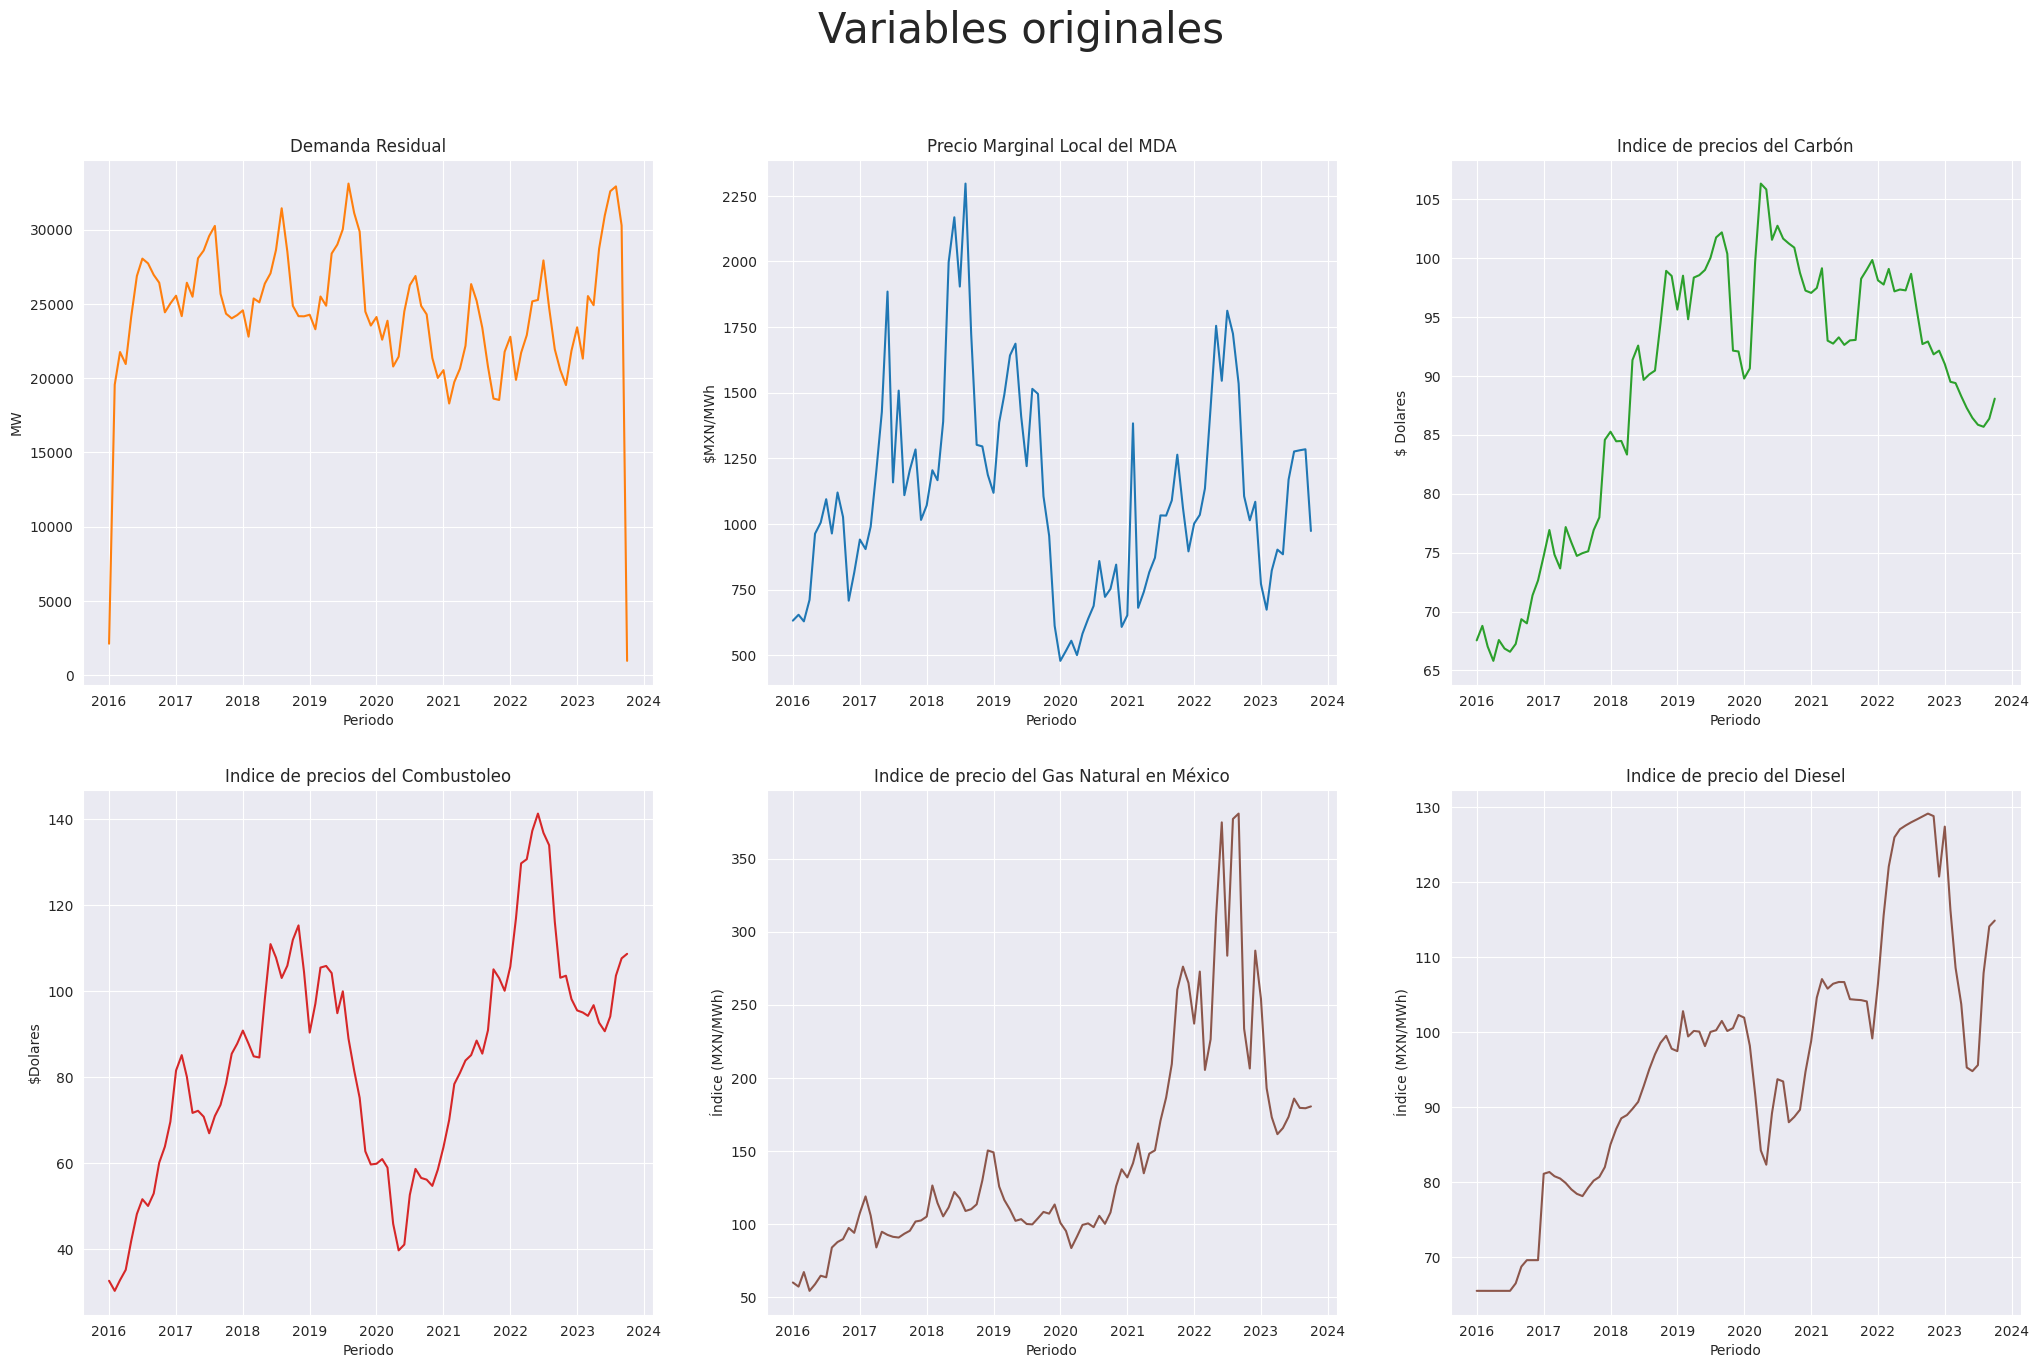

In [34]:
y_resid = df_rwc['resid']
x_pml_mda = df_rwc['PML_MDA']

x_coalprice = df_rwc['carbon_pi']
x_combustoleop = df_rwc['combustoleo']
x_gas_index = df_rwc['gas_natural_pi']
x_diesel_pi = df_rwc['diesel']

x = df_rwc['fecha']

sns.set_style("darkgrid")

fig, axs = plt.subplots(2,3, figsize=(25, 15))
fig.suptitle('Variables originales', fontsize=30)

axs[0,0].plot(x, y_resid, 'tab:orange')
axs[0,0].set_title('Demanda Residual')
axs[0,0].set_ylabel('MW')
axs[0,0].set_xlabel('Periodo')

axs[0,1].plot(x, x_pml_mda, 'tab:blue')
axs[0,1].set_title('Precio Marginal Local del MDA')
axs[0,1].set_ylabel('$MXN/MWh')
axs[0,1].set_xlabel('Periodo')


axs[0,2].plot(x, x_coalprice, 'tab:green')
axs[0,2].set_title('Indice de precios del Carbón')
axs[0,2].set_ylabel('$ Dolares')
axs[0,2].set_xlabel('Periodo')

axs[1,0].plot(x, x_combustoleop, 'tab:red')
axs[1,0].set_title('Indice de precios del Combustoleo')
axs[1,0].set_ylabel('$Dolares')
axs[1,0].set_xlabel('Periodo')

axs[1,1].plot(x, x_gas_index, 'tab:brown')
axs[1,1].set_title('Indice de precio del Gas Natural en México')
axs[1,1].set_ylabel('Índice (MXN/MWh)')
axs[1,1].set_xlabel('Periodo')

axs[1,2].plot(x, x_diesel_pi, 'tab:brown')
axs[1,2].set_title('Indice de precio del Diesel')
axs[1,2].set_ylabel('Índice (MXN/MWh)')
axs[1,2].set_xlabel('Periodo')


## Outlier correction

In [35]:
# median_co2 = df_rwc['CO2Price'].median()
# #std_co2 = df_energetics['CO2Price'].std()
# # outliers_co2 = (df_energetics['CO2Price'] - median_co2).abs() > std_co2
# # df_energetics['CO2Price'][outliers_co2] = np.nan
# # df_energetics['CO2Price'].fillna(median_co2, inplace=True)

# print(median_co2)
# df_query = df_rwc.loc[df_rwc['CO2Price'] > 80]
# print(df_query)

# df_rwc.loc[8,['CO2Price']] = median_co2
# df_rwc.loc[20,['CO2Price']] = median_co2


# Tratamiento outliers de Demanda Residual
median_resid = df_rwc['resid'].median()
df_query_resid = df_rwc.loc[df_rwc['resid'] >= 29800]
df_query_resid_low = df_rwc.loc[df_rwc['resid'] < 10000]

print(df_query_resid)
print(df_query_resid_low)

df_rwc.loc[0,['resid']] = median_resid
df_rwc.loc[19,['resid']] = median_resid
df_rwc.loc[31,['resid']] = median_resid
df_rwc.loc[42,['resid']] = median_resid
df_rwc.loc[43,['resid']] = median_resid
df_rwc.loc[44,['resid']] = median_resid
df_rwc.loc[45,['resid']] = median_resid
df_rwc.loc[89,['resid']] = median_resid
df_rwc.loc[90,['resid']] = median_resid
df_rwc.loc[91,['resid']] = median_resid
df_rwc.loc[92,['resid']] = median_resid
df_rwc.loc[93,['resid']] = median_resid

print('----------------------------------')
# Tratamiento de outliers de PML MDA
median_pml = df_rwc['PML_MDA'].median()
df_query_pml = df_rwc.loc[df_rwc['PML_MDA'] >= 1500]
print(df_query_pml)


df_rwc.loc[17,['PML_MDA']] = median_pml
df_rwc.loc[19,['PML_MDA']] = median_pml
df_rwc.loc[28,['PML_MDA']] = median_pml
df_rwc.loc[29,['PML_MDA']] = median_pml
df_rwc.loc[30,['PML_MDA']] = median_pml
df_rwc.loc[31,['PML_MDA']] = median_pml
df_rwc.loc[32,['PML_MDA']] = median_pml
df_rwc.loc[39,['PML_MDA']] = median_pml
df_rwc.loc[40,['PML_MDA']] = median_pml
df_rwc.loc[43,['PML_MDA']] = median_pml
df_rwc.loc[76,['PML_MDA']] = median_pml
df_rwc.loc[77,['PML_MDA']] = median_pml
df_rwc.loc[78,['PML_MDA']] = median_pml
df_rwc.loc[79,['PML_MDA']] = median_pml
df_rwc.loc[80,['PML_MDA']] = median_pml

print('----------------------------------')

df_query_minpml = df_rwc.loc[df_rwc['PML_MDA'] < 600]
print(df_query_minpml)


df_rwc.loc[48,['PML_MDA']] = median_pml
df_rwc.loc[49,['PML_MDA']] = median_pml
df_rwc.loc[50,['PML_MDA']] = median_pml
df_rwc.loc[51,['PML_MDA']] = median_pml
df_rwc.loc[52,['PML_MDA']] = median_pml

# Tratamiento Outliers gas natural

mean_gas = df_rwc['gas_natural_pi'].mean()
print(mean_gas)
df_query = df_rwc.loc[df_rwc['gas_natural_pi'] > 150]
print(df_query)


df_query2 = df_rwc.loc[df_rwc['gas_natural_pi'] < 10]
print(df_query2)

df_rwc.loc[89,['gas_natural_pi']] = mean_gas
df_rwc.loc[90,['gas_natural_pi']] = mean_gas
df_rwc.loc[91,['gas_natural_pi']] = mean_gas
df_rwc.loc[92,['gas_natural_pi']] = mean_gas
df_rwc.loc[93,['gas_natural_pi']] = mean_gas

         FECHA  anio  mes  PML_MDA   LOAD_MW     resid   periodo  \
19  2017-08-01  2017    8  1507.93  35044.53  30247.36  Ago 2017   
31  2018-08-01  2018    8  2296.85  36241.05  31434.21  Ago 2018   
42  2019-07-01  2019    7  1220.16  36225.83  30020.95  Jul 2019   
43  2019-08-01  2019    8  1514.67  38270.88  33097.36  Ago 2019   
44  2019-09-01  2019    9  1495.41  35138.95  31118.34  Sep 2019   
45  2019-10-01  2019   10  1105.36  33944.28  29861.72  Oct 2019   
89  2023-06-01  2023    6  1168.84  38604.57  30943.32  Jun 2023   
90  2023-07-01  2023    7  1275.95  40259.91  32578.88  Jul 2023   
91  2023-08-01  2023    8  1280.62  40228.40  32908.35  Ago 2023   
92  2023-09-01  2023    9  1284.43  37525.50  30278.00  Sep 2023   

    gas_natural_pi   carbon_pi  gasolina_pi  ...   carbon_d  gasolina_d  \
19       90.726652   74.954035    80.627222  ...   7.704464   10.926975   
31      108.887629   90.116855    98.081451  ...  15.162821   17.454229   
42      100.000000  100.00

## Deseasonalizing Data

In [36]:
# y_resid = df_rwc['RESID_DEMAND_MW']
# y_pml_mda = df_rwc['PML_MDA']

# y_coalprice = df_rwc['CoalPrice']
# y_co2price = df_rwc['CO2Price']
# y_gas_index = df_rwc['Índice (MXN/MWh)']

# resid_demand_seasonal = seasonal_decompose(y_resid, model = 'multiplicative', period = 12)
# y_resid_sa = y_resid / resid_demand_seasonal.seasonal

# pmlMDA_seasonal = seasonal_decompose(y_pml_mda, model = 'multiplicative', period = 12)
# y_pmlMDA_sa = y_pml_mda / pmlMDA_seasonal.seasonal

# print(y_resid_sa)
# print(y_pmlMDA_sa)





Text(0.5, 0, 'Periodo')

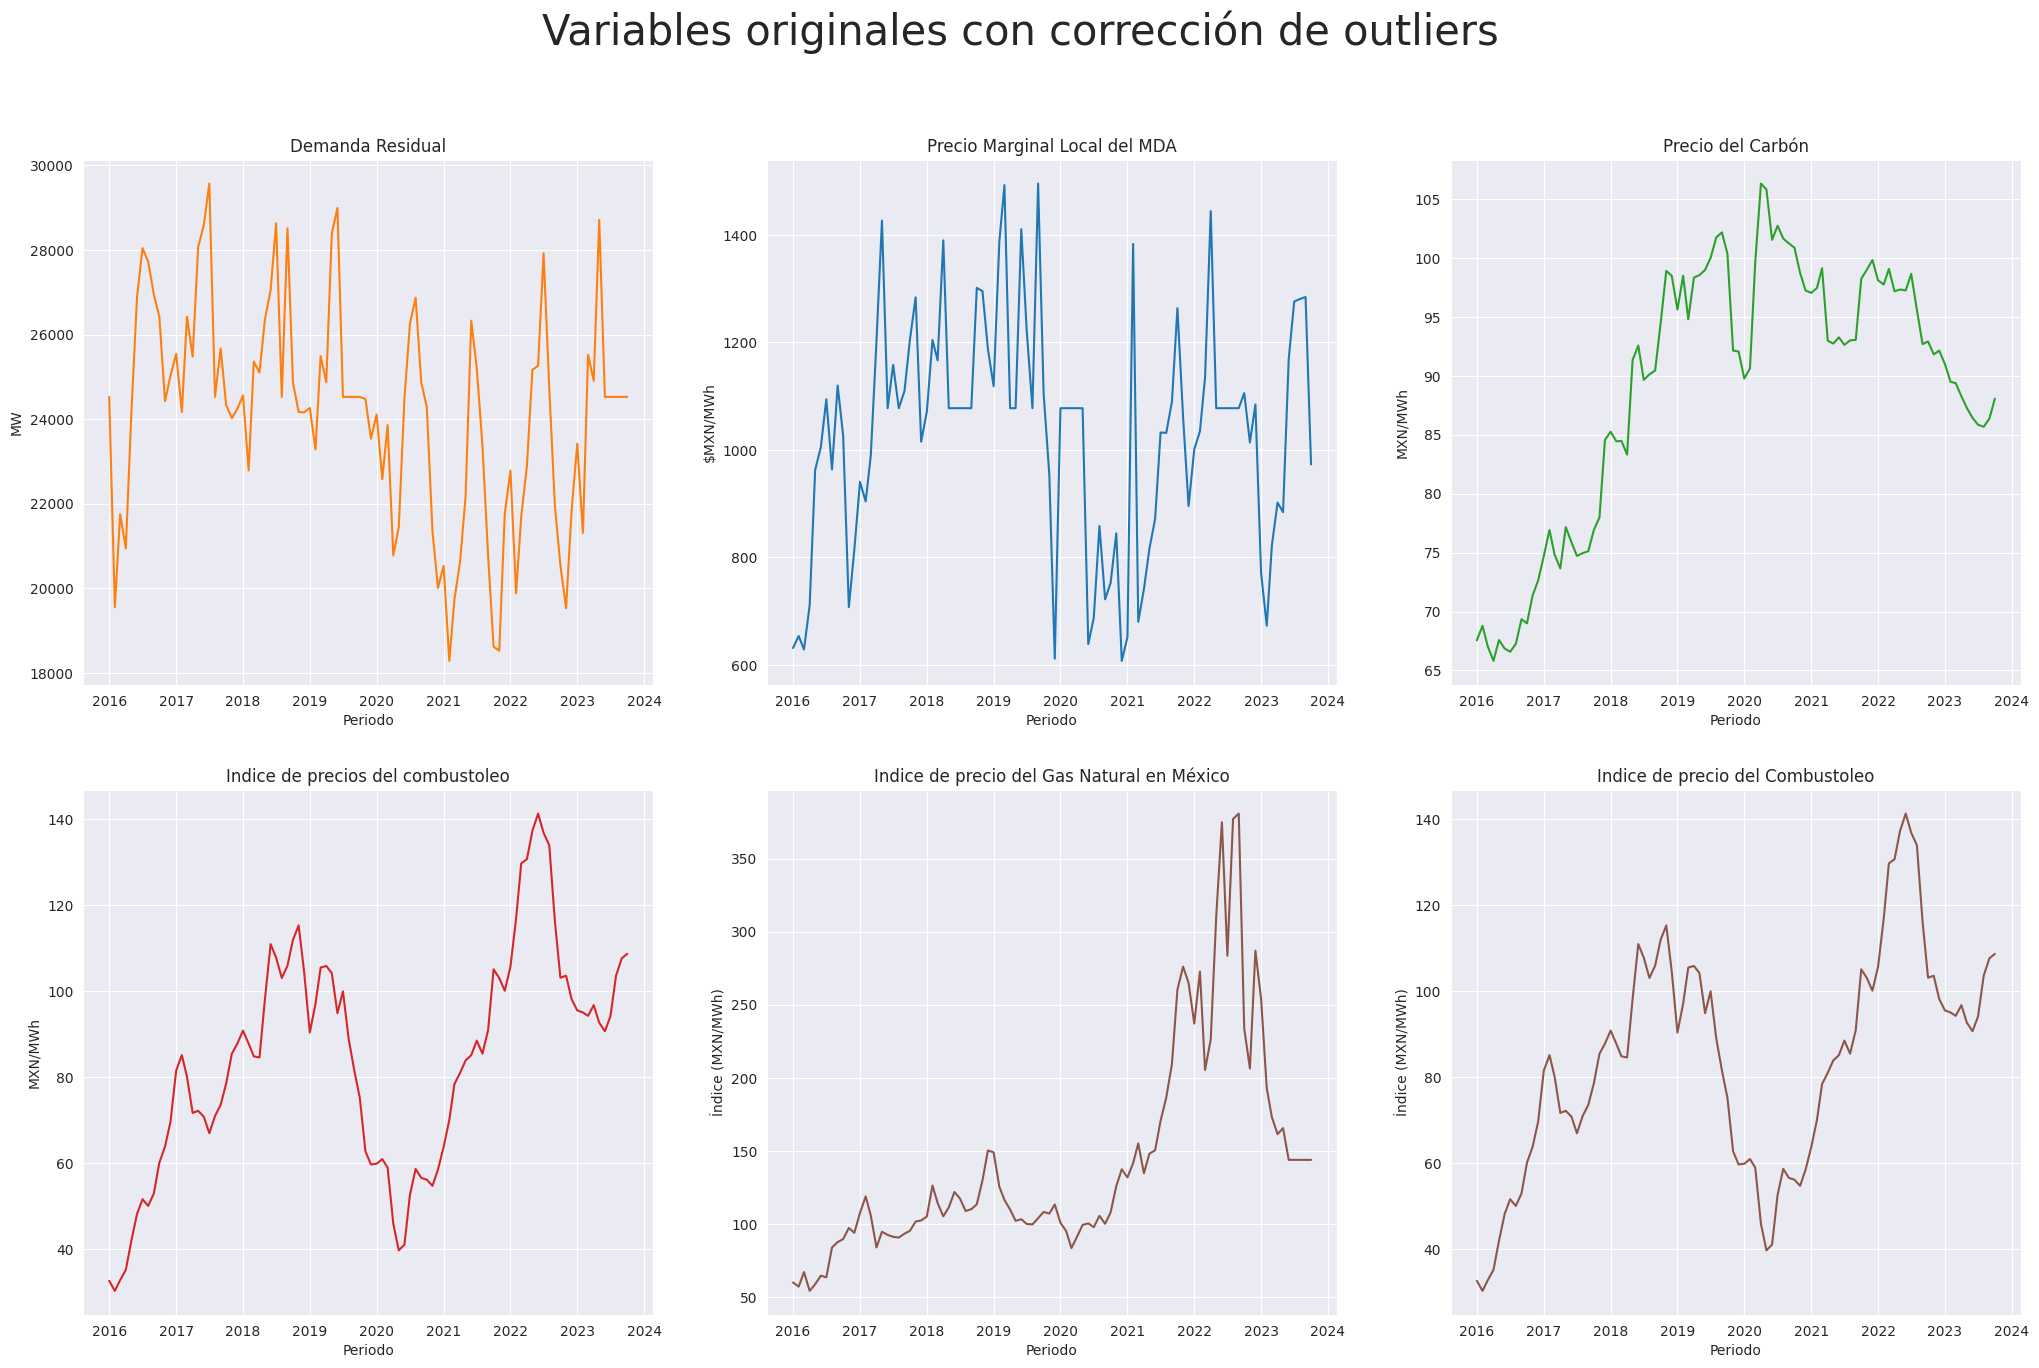

In [37]:
y_resid = df_rwc['resid']
x_pml_mda = df_rwc['PML_MDA']

x_coalprice = df_rwc['carbon_pi']
x_combustoleop = df_rwc['combustoleo']
x_gas_index = df_rwc['gas_natural_pi']
x_diesel_pi = df_rwc['diesel']

x = df_rwc['fecha']

sns.set_style("darkgrid")

fig, axs = plt.subplots(2,3, figsize=(25, 15))

fig.suptitle('Variables originales con corrección de outliers', fontsize=30)

axs[0,0].plot(x, y_resid, 'tab:orange')
axs[0,0].set_title('Demanda Residual')
axs[0,0].set_ylabel('MW')
axs[0,0].set_xlabel('Periodo')

axs[0,1].plot(x, x_pml_mda, 'tab:blue')
axs[0,1].set_title('Precio Marginal Local del MDA')
axs[0,1].set_ylabel('$MXN/MWh')
axs[0,1].set_xlabel('Periodo')


axs[0,2].plot(x, x_coalprice, 'tab:green')
axs[0,2].set_title('Precio del Carbón')
axs[0,2].set_ylabel('MXN/MWh')
axs[0,2].set_xlabel('Periodo')

axs[1,0].plot(x, x_combustoleop, 'tab:red')
axs[1,0].set_title('Indice de precios del combustoleo')
axs[1,0].set_ylabel('MXN/MWh')
axs[1,0].set_xlabel('Periodo')

axs[1,1].plot(x, x_gas_index, 'tab:brown')
axs[1,1].set_title('Indice de precio del Gas Natural en México')
axs[1,1].set_ylabel('Índice (MXN/MWh)')
axs[1,1].set_xlabel('Periodo')

axs[1,2].plot(x, x_combustoleop, 'tab:brown')
axs[1,2].set_title('Indice de precio del Combustoleo')
axs[1,2].set_ylabel('Índice (MXN/MWh)')
axs[1,2].set_xlabel('Periodo')


In [38]:

# x = df_rwc['fecha']

# sns.set_style("darkgrid")

# fig, axs = plt.subplots(2,3, figsize=(25, 15))

# fig.suptitle('Variables desestacionalizadas con corrección de outliers', fontsize=30)

# axs[0,0].plot(x, y_resid_sa, 'tab:orange')
# axs[0,0].set_title('Demanda Residual')
# axs[0,0].set_ylabel('MW')
# axs[0,0].set_xlabel('Periodo')

# axs[0,1].plot(x, y_pmlMDA_sa, 'tab:blue')
# axs[0,1].set_title('Precio Marginal Local del MDA')
# axs[0,1].set_ylabel('$MXN/MWh')
# axs[0,1].set_xlabel('Periodo')


# axs[0,2].plot(x, y_coalprice, 'tab:green')
# axs[0,2].set_title('Precio del Carbón')
# axs[0,2].set_ylabel('$ Dolares')
# axs[0,2].set_xlabel('Periodo')

# axs[1,0].plot(x, y_co2price, 'tab:red')
# axs[1,0].set_title('Precio de los futuros de emisión de CO2')
# axs[1,0].set_ylabel('$Dolares')
# axs[1,0].set_xlabel('Periodo')

# axs[1,1].plot(x, y_gas_index, 'tab:brown')
# axs[1,1].set_title('Indice de precio del Gas Natural en México')
# axs[1,1].set_ylabel('Índice (MXN/MWh)')
# axs[1,1].set_xlabel('Periodo')


<ipython-input-39-747900a8195a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rwc['gas_natural_pi'])


<Axes: xlabel='gas_natural_pi', ylabel='Density'>

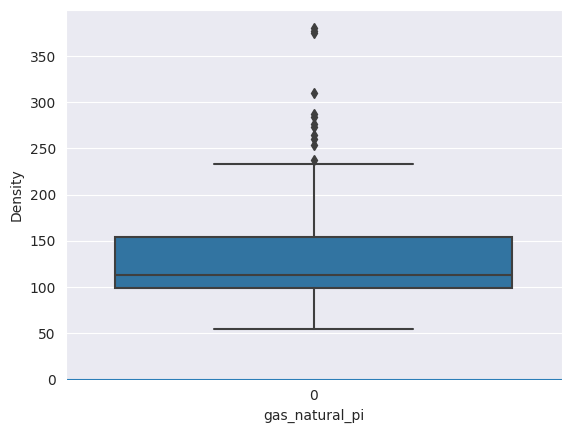

In [39]:
sns.distplot(df_rwc['gas_natural_pi'])

sns.boxplot(df_rwc['gas_natural_pi'])

## Pruebas de Estacionariedad

* ADF H0: Tiene raíz unitaria, no es estacionaria
* KPSS H0: Es estacionaria

* Se concluye que PMLs, demanda y indice de precios del gas son estacionarios a niveles

In [40]:
adf_resid = adfuller(y_resid)[1]
print('ADF P-value de la Demanda Residual', adf_resid)

kpss_resid = kpss(y_resid)
print('KPSS P-value de la Demanda Residual', kpss_resid)

print('-----------------------------------------', end='\n\n')

adf_pml = adfuller(x_pml_mda)
print('ADF P-value del PML_MDA', adf_pml)

kpss_pml = kpss(x_pml_mda)
print('KPSS P-value del PML MDA', kpss_pml)

print('-----------------------------------------', end='\n\n')

adf_gas = adfuller(x_gas_index)[1]
print('ADF P-value del indice de precios gas natural', adf_gas)

kpss_gas = kpss(x_gas_index)
print('KPSS P-value del indice de precios gas natural', kpss_gas)


print('-----------------------------------------', end='\n\n')

adf_coal = adfuller(x_coalprice)
print('ADF P-value precio del carbon', adf_coal)

kpss_coal = kpss(x_coalprice)
print('KPSS P-value precio del carbon', kpss_coal)


print('-----------------------------------------', end='\n\n')

adf_co2 = adfuller(x_combustoleop)
print('ADF P-value precio del combustoleo', adf_co2)

kpss_co2 = kpss(x_combustoleop)
print('KPSS P-value precio del combustoleo', kpss_co2)


ADF P-value de la Demanda Residual 0.657253605780252
KPSS P-value de la Demanda Residual (0.5422331217377059, 0.0321547023113275, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
-----------------------------------------

ADF P-value del PML_MDA (-5.467234764347364, 2.443358748328124e-06, 0, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 1079.2189747902728)
KPSS P-value del PML MDA (0.15448224651678627, 0.1, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
-----------------------------------------

ADF P-value del indice de precios gas natural 0.2572702912884602
KPSS P-value del indice de precios gas natural (0.9882674844586831, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
-----------------------------------------

ADF P-value precio del carbon (-1.9710107311369753, 0.2994267105391034, 0, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 387.3440481192348)
KPSS P-value 

<ipython-input-40-ab795388e0f3>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_pml = kpss(x_pml_mda)
<ipython-input-40-ab795388e0f3>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_gas = kpss(x_gas_index)
<ipython-input-40-ab795388e0f3>:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_coal = kpss(x_coalprice)


In [41]:
# # Calcular primera diferencias para precio del carbón y co2
# df_rwc['CoalPrice_diff'] = df_rwc['CoalPrice'].diff(periods = 1)
# mean_coal_diff = df_rwc['CoalPrice_diff'].mean()
# df_rwc.loc[0,['CoalPrice_diff']] = mean_coal_diff


# # Se aplica tasa de crecimiento de precios de carbon
# df_rwc['CoalPrice_l1'] = df_rwc['CoalPrice'].shift(1)
# median_col = df_rwc['CoalPrice'][0]
# df_rwc.loc[0,['CoalPrice_l1']] = median_col

# df_rwc['CoalPrice_tc'] = (np.log(df_rwc['CoalPrice']) - np.log(df_rwc['CoalPrice_l1'])) * 100


# df_rwc

# Estimacion

In [42]:
df_rwc.corr()

<ipython-input-42-d7d418d0f2dc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_rwc.corr()


,anio,mes,PML_MDA,LOAD_MW,resid,gas_natural_pi,carbon_pi,gasolina_pi,diesel,combustoleo,gas_natural_d,carbon_d,gasolina_d,diesel_d,combustoleo_d,gas_natural_pct,carbon_pct,gasolina_pct,diesel_pct,combustoleo_pct
anio,1.000000,-0.049415,0.006121,0.125081,-0.335306,0.688330,0.645997,0.866384,0.852517,0.529235,-0.059349,-0.606141,-0.156477,-0.138939,-0.038290,-0.039347,-0.647798,-0.188340,-0.170222,-0.041966
mes,-0.049415,1.000000,0.046830,0.133679,0.039509,0.099521,0.072668,0.021375,0.030319,0.074386,0.026491,0.000317,0.009124,0.033466,0.034701,0.051345,0.001466,0.000605,0.036096,-0.030715
PML_MDA,0.006121,0.046830,1.000000,0.289978,0.205619,0.083467,0.121616,0.201078,0.175370,0.462706,-0.011519,0.315357,0.215436,0.222570,0.241351,0.006079,0.308631,0.225284,0.267973,0.176163
LOAD_MW,0.125081,0.133679,0.289978,1.000000,0.370837,0.086731,0.154401,0.205424,0.126387,0.228921,-0.096773,-0.033196,0.056642,-0.011711,-0.000434,-0.030451,-0.034610,0.063314,0.022510,0.037765
resid,-0.335306,0.039509,0.205619,0.370837,1.000000,-0.304902,-0.277428,-0.229041,-0.278841,0.047832,-0.171986,0.261039,-0.020701,-0.062413,0.000572,-0.155765,0.291220,0.036364,0.007081,0.027806
gas_natural_pi,0.688330,0.099521,0.083467,0.086731,-0.304902,1.000000,0.425565,0.799343,0.800138,0.710948,0.543777,-0.297915,0.353925,0.382176,0.439256,0.518127,-0.331045,0.277797,0.323648,0.330428
carbon_pi,0.645997,0.072668,0.121616,0.154401,-0.277428,0.425565,1.000000,0.672033,0.685182,0.424154,0.157227,-0.006468,0.024743,0.063292,-0.004253,0.028119,-0.080243,-0.040724,0.007418,-0.051681
gasolina_pi,0.866384,0.021375,0.201078,0.205424,-0.229041,0.799343,0.672033,1.000000,0.975277,0.803082,0.179552,-0.342338,0.270724,0.265057,0.286571,0.158240,-0.378742,0.212445,0.227051,0.202251
diesel,0.852517,0.030319,0.175370,0.126387,-0.278841,0.800138,0.685182,0.975277,1.000000,0.759819,0.194828,-0.338232,0.263060,0.329206,0.254581,0.138222,-0.377617,0.194895,0.276139,0.166337
combustoleo,0.529235,0.074386,0.462706,0.228921,0.047832,0.710948,0.424154,0.803082,0.759819,1.000000,0.288237,0.050982,0.477889,0.455890,0.610093,0.314665,0.044174,0.460000,0.470475,0.489241


In [43]:
df_rwc.describe()

,anio,mes,PML_MDA,LOAD_MW,resid,gas_natural_pi,carbon_pi,gasolina_pi,diesel,combustoleo,gas_natural_d,carbon_d,gasolina_d,diesel_d,combustoleo_d,gas_natural_pct,carbon_pct,gasolina_pct,diesel_pct,combustoleo_pct
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,2019.425532,6.393617,1031.888830,30429.116170,24169.996489,141.966894,89.001382,96.789586,95.637429,83.820633,17.342871,3.021114,5.576325,5.501323,5.061044,24.118692,4.482748,7.413415,7.333406,17.235988
std,2.269429,3.427335,216.970293,5436.844449,2571.090940,72.085399,11.126529,17.057139,17.282767,25.759902,71.298765,8.046206,12.768278,13.309532,32.431950,44.969090,9.485398,13.532921,13.557222,50.020490
min,2016.000000,1.000000,607.500000,1137.180000,18283.970000,54.247171,65.815401,65.150230,65.494644,30.294812,-201.578756,-13.322596,-28.411975,-32.729283,-64.521548,-53.745904,-12.977420,-28.197462,-25.670023,-61.898859
25%,2017.250000,3.250000,897.037500,28289.407500,22632.077500,99.439283,83.595456,83.085084,82.064459,63.014517,-4.851896,-2.216812,-1.374499,-2.040422,-23.270785,-4.524463,-2.194774,-1.619578,-3.021243,-25.813097
50%,2019.000000,6.000000,1077.540000,30290.590000,24525.380000,113.381811,92.129443,99.468060,97.595938,85.478770,12.642761,4.718196,8.455556,8.093437,8.085663,8.826055,5.361376,9.278565,10.013890,10.985461
75%,2021.000000,9.000000,1131.212500,33568.280000,25488.775000,153.919568,98.301976,106.224867,104.522411,103.141217,43.775916,7.956724,15.252147,15.284605,32.322913,49.585904,11.613773,18.543557,19.196971,52.708019
max,2023.000000,12.000000,1495.410000,40259.910000,29568.750000,380.753102,106.299787,130.359538,129.087513,141.353082,224.359553,20.911021,33.368768,24.853544,56.200863,149.192009,26.813695,46.122089,29.288905,181.050542


In [44]:
#df_rwc = df_rwc.loc[(df_rwc['fecha'] >= '2016-01-01') & (df_rwc['fecha'] < '2022-01-01') ]

## Determinación de precios extremos
* Variable objetivo para logit

In [45]:
mean_pml = df_rwc['PML_MDA'].mean()
std_dev_pml = df_rwc['PML_MDA'].std()

df_rwc['z_score'] = (df_rwc['PML_MDA'] - mean_pml) / std_dev_pml

df_rwc['extremePrices'] = df_rwc['z_score'].apply(lambda x: 1 if abs(x) > 3 else 0)

df_rwc['extremePrices'] = df_rwc['PML_MDA'].apply(lambda x: 1 if abs(x) >= 1000 else 0)

df_rwc['intercept'] = 1


print(mean_pml, std_dev_pml)

query_df = df_rwc.loc[df_rwc['extremePrices'] == 1]


query_df





1031.8888297872338 216.9702932436346


,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,gas_natural_pi,carbon_pi,gasolina_pi,...,combustoleo_d,gas_natural_pct,carbon_pct,gasolina_pct,diesel_pct,combustoleo_pct,fecha,z_score,extremePrices,intercept
5,2016-06-01,2016,6,1005.14,31875.96,26872.15,Jun 2016,64.604943,66.859997,66.557092,...,-23.713652,6.217962,3.870086,-3.156924,-3.021371,-32.986774,2016-06-01,-0.123283,1,1
6,2016-07-01,2016,7,1094.15,33171.57,28043.65,Jul 2016,63.519870,66.586996,67.658579,...,-19.835519,3.346219,1.868247,-1.680107,-3.022451,-27.760137,2016-07-01,0.286957,1,1
8,2016-09-01,2016,9,1119.76,31403.75,26948.20,Sep 2016,87.654649,69.348014,70.034915,...,-0.389728,40.598746,2.045201,2.232144,1.763564,-0.730568,2016-09-01,0.404992,1,1
9,2016-10-01,2016,10,1026.37,30883.04,26420.98,Oct 2016,89.649447,68.997621,70.494862,...,7.073102,50.128789,7.569489,3.852312,3.030878,13.332849,2016-10-01,-0.025436,1,1
15,2017-04-01,2017,4,1202.56,29645.30,25477.45,Abr 2017,83.959058,73.655995,81.728275,...,36.511814,54.771311,11.913007,24.014598,22.849556,103.758360,2017-04-01,0.786611,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2022-12-01,2022,12,1084.40,28634.41,21836.45,Dic 2022,286.990021,92.129594,105.976186,...,-1.935368,8.338250,-7.701419,-0.608396,21.754208,-1.932942,2022-12-01,0.242020,1,1
89,2023-06-01,2023,6,1168.84,38604.57,24525.38,Jun 2023,143.868985,86.424281,105.501430,...,-50.644610,-53.745904,-11.123759,-18.858986,-25.670023,-35.828444,2023-06-01,0.631198,1,1
90,2023-07-01,2023,7,1275.95,40259.91,24525.38,Jul 2023,143.868985,85.844152,104.223886,...,-42.729733,-34.476421,-12.977420,-20.048899,-25.285265,-31.216476,2023-07-01,1.124860,1,1
91,2023-08-01,2023,8,1280.62,40228.40,24525.38,Ago 2023,143.868985,85.670731,115.655803,...,-30.364135,-52.419043,-10.368833,-10.396032,-15.955665,-22.659427,2023-08-01,1.146384,1,1


In [46]:
resid = df_rwc['resid']

resid_2 = resid ** 2
resid_3 = resid ** 3

# resid_sa_2 = y_resid_sa ** 2
# resid_sa_3 = y_resid_sa ** 3

df_rwc['resid'] = resid
df_rwc['resid_2'] = resid ** 2
df_rwc['resid_3'] = resid ** 3

# df_rwc['pmlMDA_sa'] = y_pmlMDA_sa
# df_rwc['resid_sa'] = y_resid_sa
# df_rwc['resid_sa_2'] = y_resid_sa**2
# df_rwc['resid_sa_3'] = y_resid_sa**3


x_features = ['intercept', 'gas_natural_pi', 'combustoleo',  'carbon_pi', 'LOAD_MW']
x_features_1 = ['intercept', 'combustoleo', 'diesel', 'gas_natural_pi', 'carbon_pi', 'resid']
x_features_2 = ['resid', 'gas_natural_pct', 'carbon_pct', 'combustoleo_pct']

x_features_4 = ['intercept', 'gas_natural_pi', 'carbon_pi', 'combustoleo', 'diesel']

x_features_5 = ['resid', 'LOAD_MW', 'PML_MDA', 'gas_natural_d']

y = df_rwc['extremePrices']
#y = df_rwc['pmlMDA_sa']
X = df_rwc[x_features_1]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


print(X_train)

    intercept  combustoleo      diesel  gas_natural_pi   carbon_pi     resid
83          1    98.190118  120.694919      286.990021   92.129594  21836.45
35          1   104.519185   97.757890      150.303954   98.464730  24157.80
90          1    94.152254   95.576517      143.868985   85.844152  24525.38
62          1    78.415962  107.035163      155.098393   99.116196  19732.06
12          1    81.565020   81.093721      107.553961   74.718542  25545.75
..        ...          ...         ...             ...         ...       ...
60          1    63.774502   98.762937      131.872442   97.028400  20532.30
71          1   100.125486   99.129977      264.901843   99.816913  21767.94
14          1    80.120018   80.767667      105.759252   74.823919  26419.13
92          1   107.666490  114.051771      143.868985   86.358952  24525.38
51          1    45.907225   84.210367       91.361165  106.299787  20777.46

[84 rows x 6 columns]


In [47]:
# Build - fit model
# X_train = sm.add_constant(X_train)
# print(X_train)
# model = sm.OLS(y_train, X_train)
# results = model.fit()

# print(results.params)

# print(results.summary())



logit = LogisticRegression(random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

score = logit.score(X_test, y_test)
print(score)


clf = sm.Logit(y_train, X_train)
model = clf.fit()

print(model.summary())

0.9
Optimization terminated successfully.
         Current function value: 0.520451
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          extremePrices   No. Observations:                   84
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.1924
Time:                        23:30:28   Log-Likelihood:                -43.718
converged:                       True   LL-Null:                       -54.134
Covariance Type:            nonrobust   LLR p-value:                 0.0008716
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -2.1483      4.374     -0.491      0.623     -10.721       6.424
combustoleo  